# Charging Network Enhancement Optimization Model

This notebook implements and solves the mixed-integer linear programming model for optimizing the Kitchener-Waterloo charging network enhancement through:

1. Model Implementation
   - Decision variable definition
   - Constraint formulation
   - Objective function development
   - Gurobi model construction

2. Scenario Analysis
   - Base case optimization
   - Budget sensitivity analysis
   - Coverage requirement variations
   - Phasing strategy options

3. Solution Analysis
   - Result visualization
   - Cost-benefit analysis 
   - Coverage improvement assessment
   - Implementation recommendations

In [1]:
# Setup and imports
import pandas as pd
import matplotlib.pyplot as plt
import json
import logging
from tabulate import tabulate

# Local imports 
from src.data.constants import *
from src.data.data_manager import DataManager
from src.model.utils import *
from src.model.network_optimizer import EVNetworkOptimizer
from src.visualization.optimization_viz import *

# Configure logging
logging.getLogger('gurobipy').setLevel(logging.ERROR)
logging.getLogger('data_manager').setLevel(logging.ERROR)

# Initialize data manager
data_mgr = DataManager()

# Load configuration
config_path = PROJECT_ROOT / 'configs' / 'base.json'
with open(config_path) as f:
    base_config = json.load(f)

print("Setup complete!")

Setup complete!


## 1. Data Preparation and Model Setup
First, let's prepare our data and initialize the optimization model

In [2]:
# Prepare input data
print("🔄 Preparing optimization data...")
input_data = data_mgr.prepare_optimization_data()

🔄 Preparing optimization data...

📊 Preparing Optimization Model Data

🔄 OPT-PREP-STEP 1.1: LOADING BASE DATA...


1️⃣ Region of Waterloo Census Data:
----------------------------------------
    📊 Regional Summary:
    ------------------------------------
    Total Population: 637,730
    Total Area: 1382.1 km²
    Average Regional Density: 461.4 people/km²

2️⃣ Statistics Canada Data:
----------------------------------------
Population Estimate: 575,847

3️⃣ UN Population Data:
----------------------------------------
Population Estimate: 622,497

📊 Source Comparison Summary:
--------------------------------------------------
Region of Waterloo: 637,730
Statistics Canada: 575,847
UN Data: 622,497

Confidence Score: 0.94

📊 OPT-PREP-STEP 1.2: LOADING CHARGING STATIONS...

Fetching Charging Stations...
📡 Retrieved 240 stations from API

📊 Charging Station Summary:
--------------------------------------------------
Total API Results: 240
Successfully Processed: 240
Skipped Records: 0
Wi

INFO:src.data.data_manager:Total population: 637,730
INFO:src.data.data_manager:Covered population: 637,040
INFO:src.data.data_manager:Total population: 637,730
INFO:src.data.data_manager:Covered population: 485,640


✓ Processed 7705 potential sites!


📏 OPT-PREP-STEP 4: CALCULATING DISTANCE MATRICES...


Site-to-Demand Distance: 100%|██████████| 7705/7705 [00:18<00:00, 420.77it/s]


Matrix Dimensions:
- Distance matrix: (7705, 379)
- Number of stations: 183
- Number of demand points: 379
- Number of potential sites: 7705

Distance Statistics:
- Mean distance: 8.26 km
- Max distance: 44.09 km
- Min distance: 0.00 km

Theoretical Coverage Possible with respect to:
 - Unlimited Budget
 - Unlimited Site Capacity
 - Unlimited Grid Capacity
 - Unlimited Charging Speed
 - Available Potential Sites

We could achieve:
 - L2 Stations (with only L2 charging ports): 95.51%
 - L3 Stations (with L2 & L3 charging ports): 98.42%


In [3]:
# Initialize optimizer
print("\n🤖 Initializing optimizer...")
optimizer = EVNetworkOptimizer(input_data, base_config)


🤖 Initializing optimizer...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2589656
Academic license 2589656 - for non-commercial use only - registered to ja___@uwaterloo.ca


In [4]:
# Program documentation
print("\n📝 Getting model documentation...")
program_doc = optimizer.get_program_doc()
program_doc_summary = get_program_doc_summary(program_doc, display=True)


📝 Getting model documentation...

              EV CHARGING NETWORK ENHANCEMENT OPTIMIZATION PROGRAM              

--------------------------------------------------------------------------------
                                1. DATA SUMMARY                                 
--------------------------------------------------------------------------------

Network Infrastructure:
+---------------+--------+-----------------------------------------------------+
|   Component   |  Size  | Description                                         |
+===============+========+=====================================================+
| Demand Points |  379   | Population demand points Weighted by:   • EV        |
|               |        | Adoption (35%)   • Infrastructure Quality (25%)   • |
|               |        | Population Density (20%)   • Transit Access (15%)   |
|               |        | • Infrastructure Age (5%)                           |
+---------------+--------+----------------------

## 2. Base Case Optimization
Now let's run our base case optimization and analyze the results:

In [5]:
# Run optimization
print("✨ Running base case optimization...")
solution = optimizer.optimize()

✨ Running base case optimization...

1. Setting up optimization model...
✓ Model parameters configured
✓ Decision variables created
✓ Constraints added
✓ Objective function set

2. Starting optimization...

3. Processing optimal solution...
✓ Found 4 L2 -> L3 upgrades!
✓ Found 44 new L2 stations!
✓ Found 11 new L3 stations!

4. Creating detailed solution...
✓ Station statuses updated
✓ Solution creation complete!


In [6]:
# Get optimization results
solution_summary = get_solution_summary(solution, display=True)


              EV CHARGING NETWORK ENHANCEMENT OPTIMIZATION RESULTS              

          Date:                                    2024-12-13 02:35:18          
          Scenario:                                               Base          
          Status:                                              optimal          
          Objective Value:                                       88.58          

--------------------------------------------------------------------------------
                                COVERAGE UPDATES                                
--------------------------------------------------------------------------------
+-----------------+-----------+---------+----------+
| Coverage Type   |   Initial |   Final |   Change |
+=================+===========+=========+==========+
| Level 2         |    14.57% |  96.14% |  +81.57% |
+-----------------+-----------+---------+----------+
| Level 3         |     1.78% |  85.40% |  +83.62% |
+-----------------+-----------+

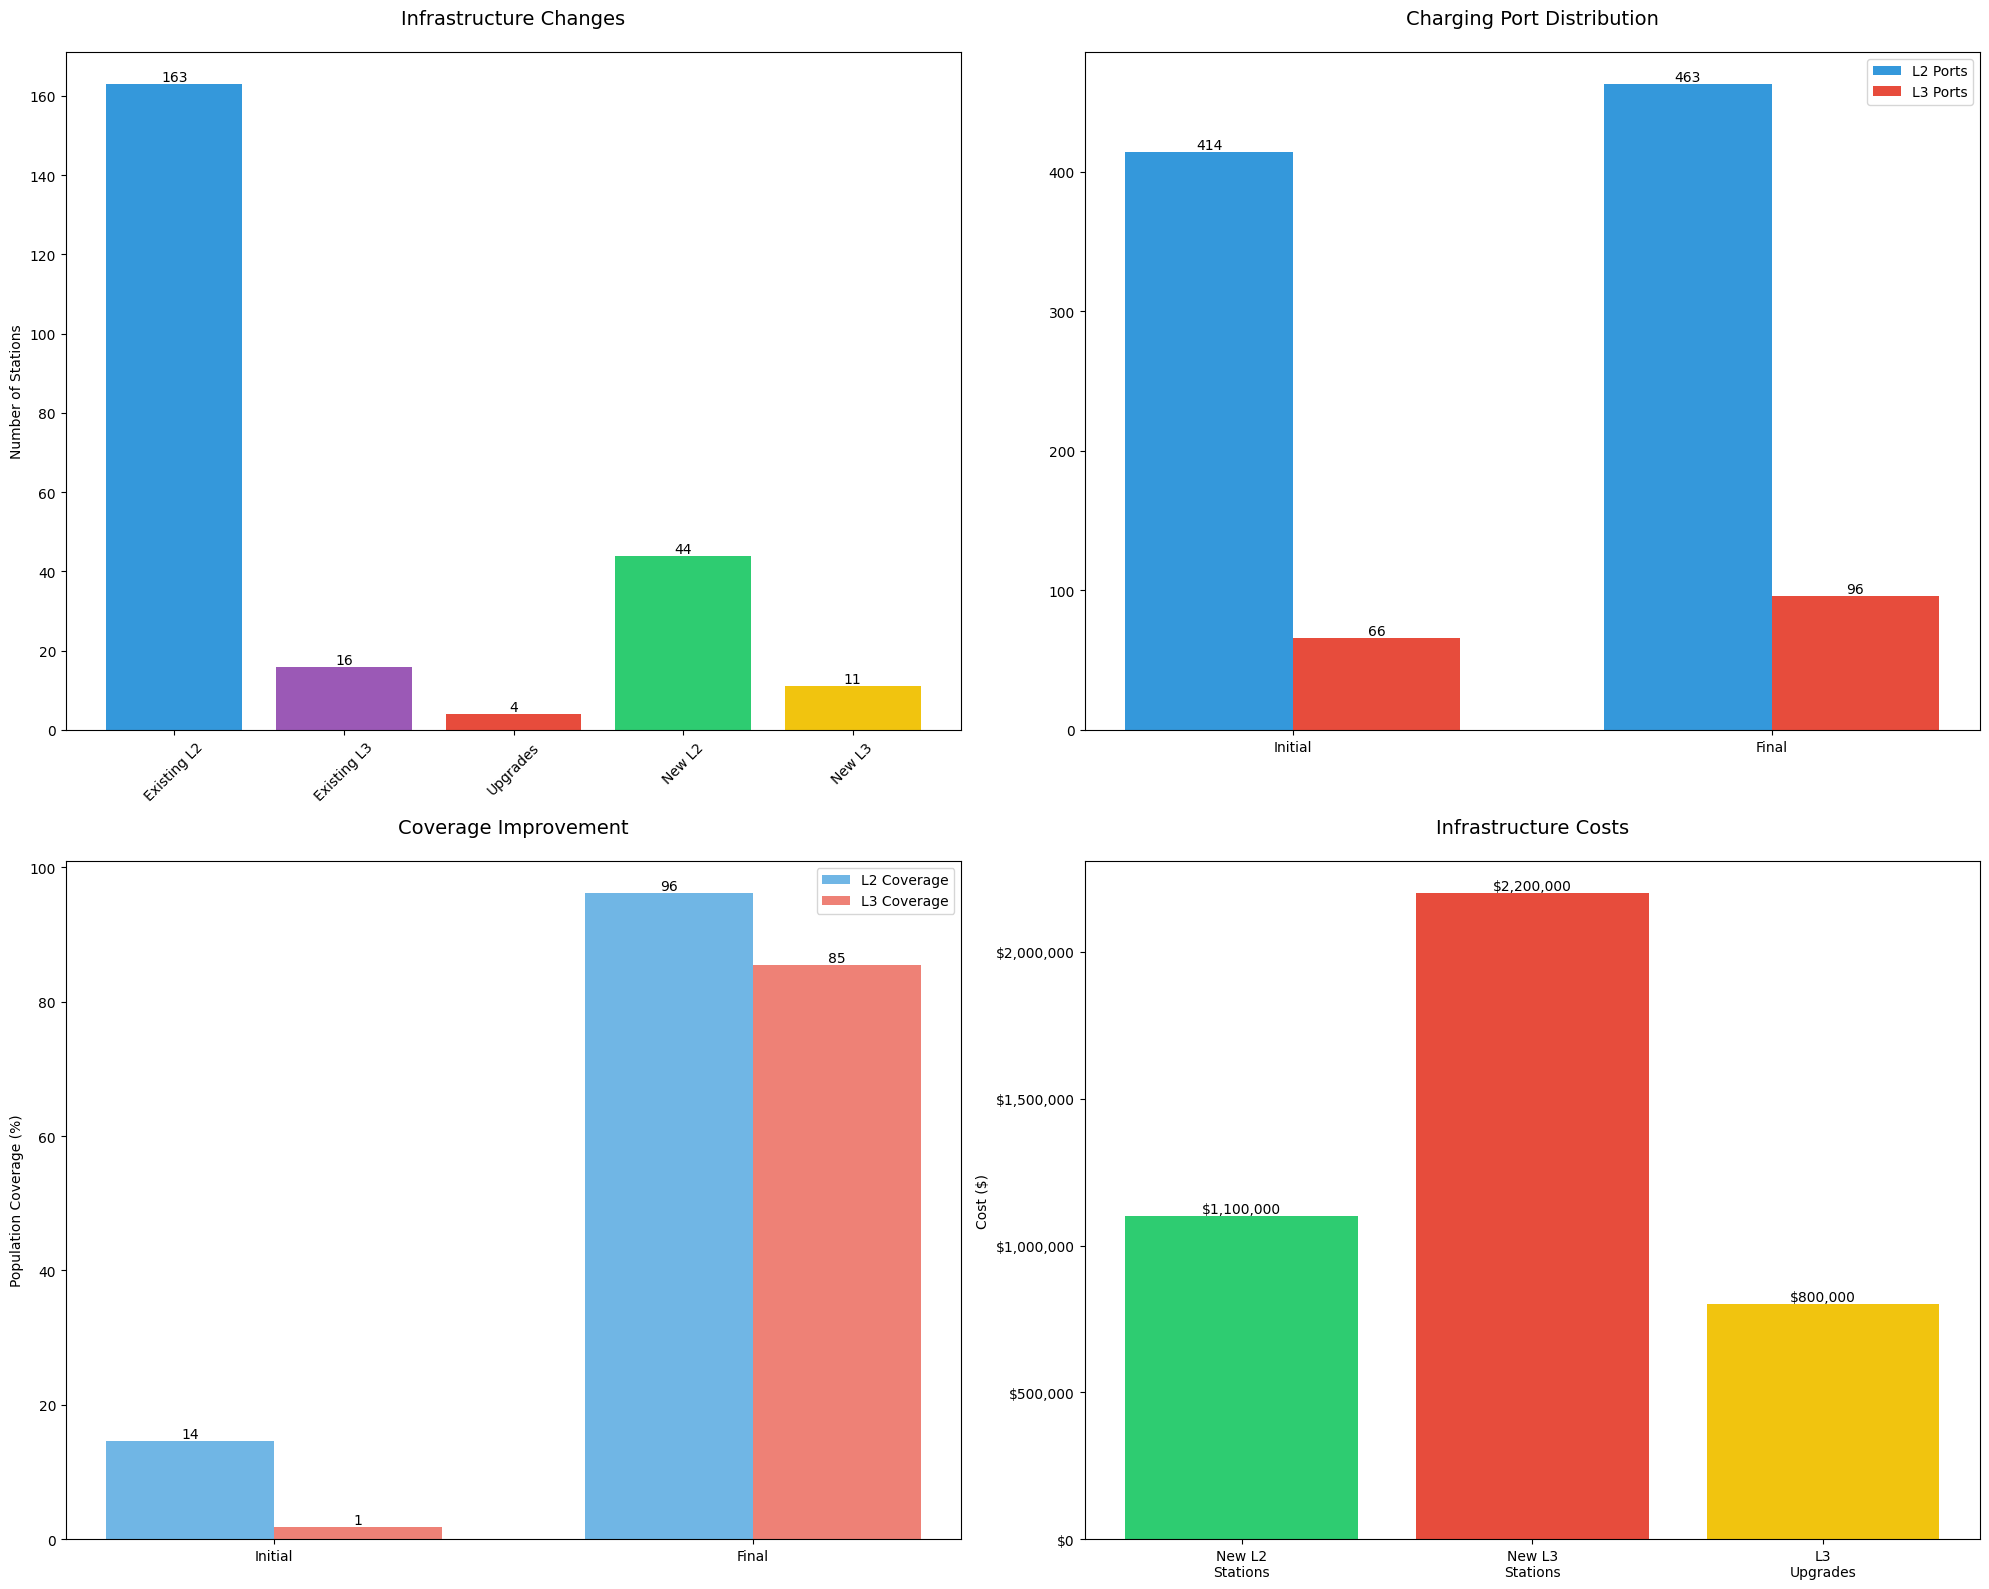

In [7]:
# Visualize optimization results
solution_plot = plot_optimization_results(solution, base_config)
display(solution_plot)

In [8]:
# Display map
map_plot = create_results_map(solution, base_config)
draw_map(map_plot)

## 3. Sensitivity Analysis
Let's analyze how our solution changes with different parameters:

In [9]:
# Run sensitivity analysis
sensitivity_results = optimizer.perform_sensitivity_analysis()
sensitivity_results_summary = get_sensitivity_results_summary(sensitivity_results, display=True)


                          SENSITIVITY ANALYSIS SUMMARY                          

--------------------------------------------------------------------------------
                              Constraint Analysis                               
--------------------------------------------------------------------------------
+--------------+---------------+---------------+--------------+-------------+
| Constraint   |   Utilization |         Slack |          RHS |   Status    |
+==============+===============+===============+==============+=============+
| Budget       |    99.875000% | +5,000.000000 | 4,000,000.00 | Non-Binding |
+--------------+---------------+---------------+--------------+-------------+
| L2 Coverage  |   101.205179% |     -0.011449 |         0.95 | Non-Binding |
+--------------+---------------+---------------+--------------+-------------+
| L3 Coverage  |   100.469404% |     -0.003990 |         0.85 | Non-Binding |
+--------------+---------------+---------------+--

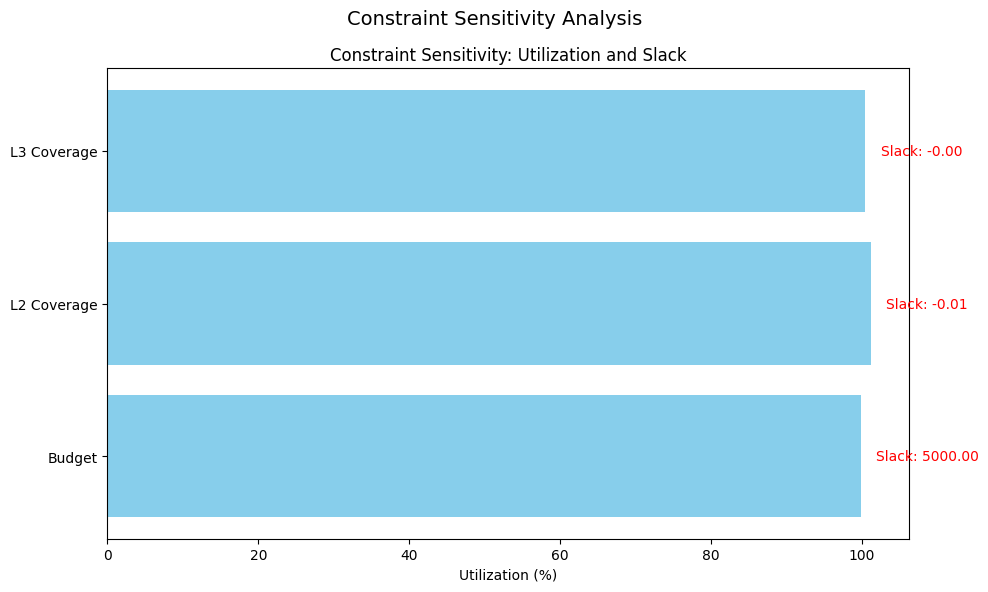

In [10]:
# Create visualization
sensitivity_plots = plot_sensitivity_analysis(sensitivity_results)
display(sensitivity_plots)

## 4. Implementation Planning
Based on our optimization results, let's develop a phased implementation plan:

In [11]:
# Create and display implementation plan
implementation_summary, implementation_plan = get_implementation_plan(solution, display=True)


                              IMPLEMENTATION PLAN                               

--------------------------------------------------------------------------------
                                 Phase Details                                  
--------------------------------------------------------------------------------

Phase 1: L2 to L3 Upgrades
   • Convert existing L2 stations to L3
   • Install new L3 ports
   • Upgrade electrical infrastructure

Phase 2: New L3 Stations
   • Install new L3 stations
   • Add L3 charging ports
   • Implement grid connections

Phase 3: New L2 Network
   • Install new L2 stations
   • Add L2 charging ports
   • Complete network coverage

--------------------------------------------------------------------------------
                            Detailed Phase Analysis                             
--------------------------------------------------------------------------------
+---------+------------+---------+-----------+-----------+-------------

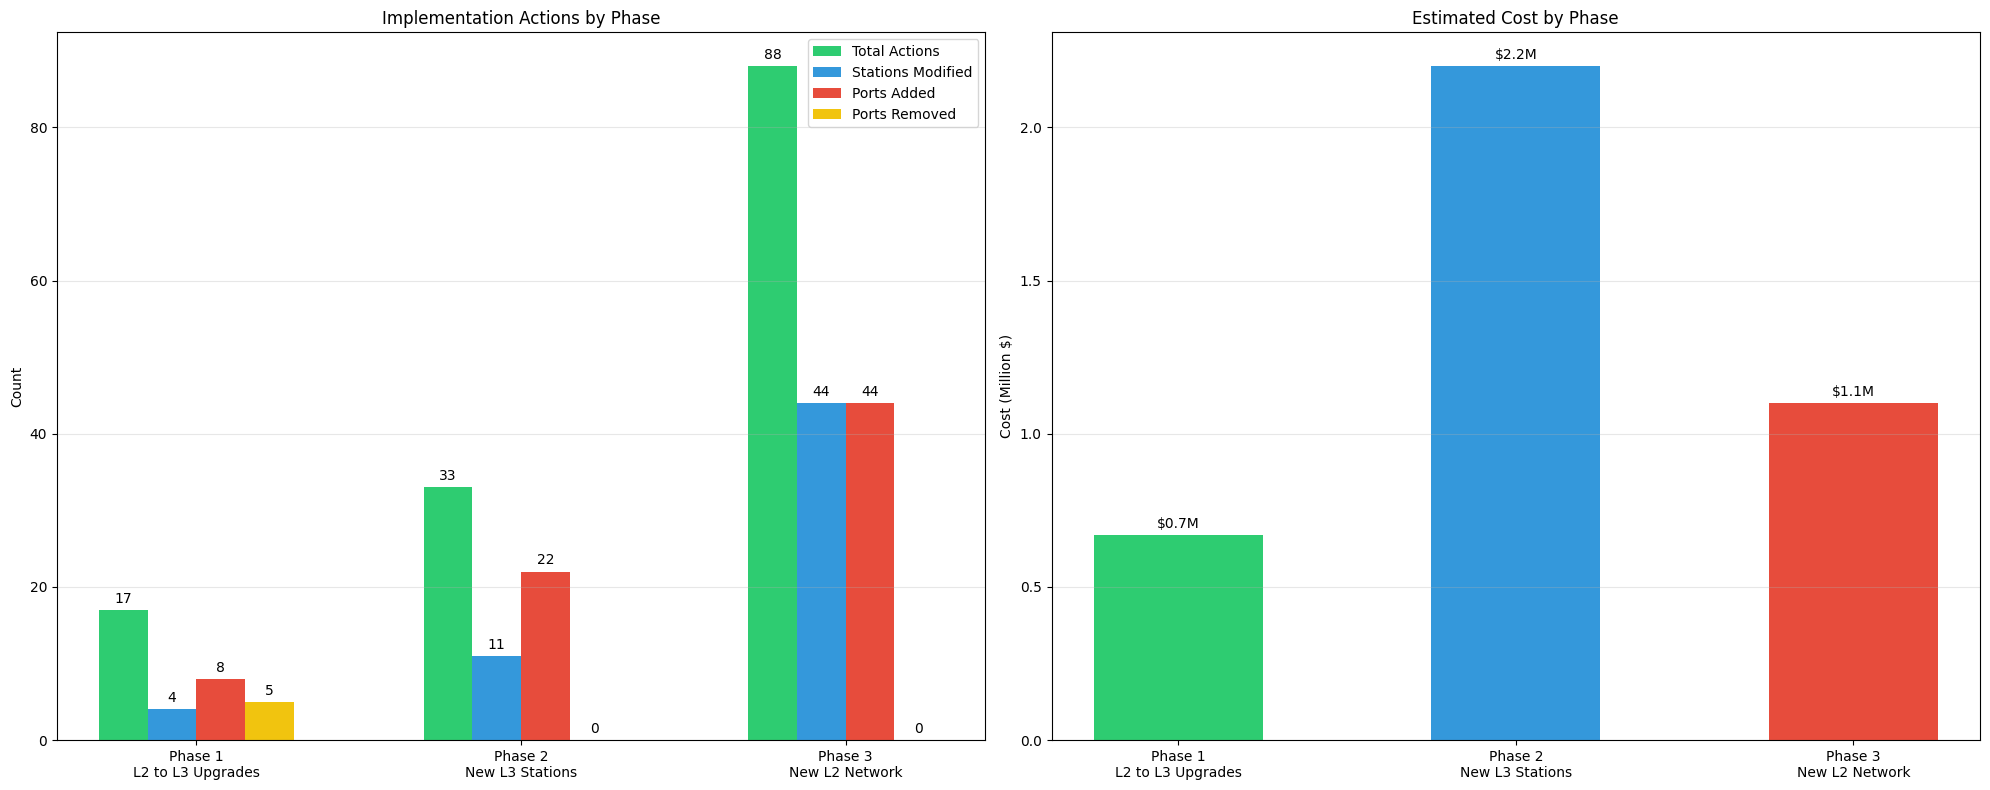

In [12]:
plot_implementation_plan(implementation_plan)

## 5. Recommendations and Next Steps

Based on our analysis, here are the key recommendations for implementation:

1. Phase 1 (Months 1-4):
   - Focus on L3 upgrades
   - Target high-traffic areas first
   - Verify grid capacity at upgrade locations

2. Phase 2 (Months 5-8):
   - Deploy new L3 stations
   - Coordinate with utility providers
   - Begin site preparation work

3. Phase 3 (Months 9-12):
   - Complete L2 network expansion
   - Monitor usage patterns
   - Adjust port allocations based on demand

Key considerations for successful implementation:
- Coordinate with utility providers early
- Develop contingency plans for construction delays
- Monitor actual usage patterns to validate model assumptions
- Consider weather impacts on construction timeline